In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../src")

In [4]:
from d01_data.access_database import *
from d03_processing.clean_measurements import *

# 1. Read relevant tables into dataframes

* `measurement_abstract_rpt`: 1,568,350 final (reported) study measurements (more than measured because some are automatically calculated)
* `a_measgraphref`: 823,886 total (recorded) instance measurements (some with bad `instanceidk`, `indexinmglist` values)
* `a_measgraphic`: 486,884 instance frames

In [5]:
path = get_db_config_path()
conf = get_db_config(path)
conn = get_sqlalchemy_connection(conf)

In [6]:
measurement_abstract_rpt_df, measgraphref_df, measgraphic_df = read_measurement_tables(conn)

Table measurement_abstract_rpt has 1568350 rows and 6 columns
Table a_measgraphref has 858255 rows and 11 columns
Table a_measgraphic has 486884 rows and 9 columns


In [7]:
measurement_abstract_rpt_df, measgraphref_df, measgraphic_df = clean_measurement_datatframes(measurement_abstract_rpt_df, measgraphref_df, measgraphic_df)

Cleaning datatframe measurement_abstract_rpt_df
Stripped string column name
Stripped string column unitname
Cleaning datatframe measgraphref_df
Dropped 28264 rows with empty strings in column instanceidk, 829991 rows remaining
Cast column instanceidk to int
Cast column indexinmglist to int
Dropped 6068 rows with negative values in column instanceidk, 823923 rows remaining
Dropped 37 rows with negative values in column indexinmglist, 823886 rows remaining
Dropped unknown column srinstanceidk
Cleaning datatframe measgraphic_df
Dropped unknown column graphictoolidk
Dropped unknown column longaxisindex
Dropped unknown column measidk
Dropped unknown column loopidk
Dropped unknown column instancerecordtype


In [8]:
measurement_abstract_rpt_df.head()

,row_id,studyid,measabstractnumber,name,value,unitname
0,1.0,2882.0,2.0,(P1/2t)AVM,2.491754,cm2
1,2.0,2882.0,12.0,Area TSVI,3.606348,cm2
2,3.0,2882.0,43.0,FE(el-ps4),37.032087,%
3,4.0,2882.0,46.0,FE(MDD-ps4),35.095355,%
4,5.0,2882.0,125.0,P1/2t VM,88.291224,ms


In [9]:
measgraphref_df.head()

,row_id,studyidk,measabstractnumber,meassequence,instanceidk,indexinmglist,value,howentered,imagesopinstanceuid,measurementuid
0,1.0,2882.0,187.0,0.0,57164,0,28.242271,0.0,,
1,2.0,2882.0,188.0,0.0,57164,0,7.897812,0.0,,
2,3.0,2882.0,189.0,0.0,57164,0,85.725750,0.0,,
3,4.0,2882.0,190.0,0.0,57164,0,87.190031,0.0,,
4,5.0,2882.0,191.0,0.0,57164,1,36.654466,0.0,,


In [10]:
measgraphic_df.head()

,row_id,instanceidk,indexinmglist,frame
0,1.0,57160.0,0.0,0.0
1,2.0,57160.0,1.0,0.0
2,3.0,57160.0,2.0,0.0
3,4.0,57160.0,3.0,0.0
4,5.0,57162.0,0.0,5.0


In [11]:
measgraphref_df['indexinmglist'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [12]:
measgraphref_df["howentered"].unique()

array([0., 3., 5.])

In [13]:
num_instances_no_uid = (measgraphref_df.groupby("instanceidk").first()["imagesopinstanceuid"] != "").sum()
num_instances_no_uid

1995

# 2. Descriptive Statistics

* 362 unique measurements
* 24,912 unique studies with final (reported) measurements
* 24,471 unique studies with total (recorded) measurements
    * 128 outliers based on instances per study
* 254,159 unique instances with total (recorded) measurements
    * 2,357 outliers based on measurements per instance
    * 31,877 outliers based on frame counts per instance

### What are the most/least common final (reported) measurements?

In [14]:
counts = measurement_abstract_rpt_df['name'].value_counts()
counts

ASC                        22447
Altura (unidad métrica)    21505
Peso (unidad métrica)      21478
IMC                        21447
ASC (Haycock)              21438
Vmáx V2 Ao                 20828
GP máx Ao                  20827
VTD(Teich)                 20623
DVItd                      20623
VTD(cúbico)                20613
SIVtd                      20548
PPVItd                     20430
DSIV/DPPVI                 20309
Masa VI(C)td               20297
Vmáx E VM                  19978
Masa VI (C)ltd             18560
Grosor relativo pared      17856
Vmáx A VM                  17617
E/A VM                     17581
VTD(MDD-ps4)               17547
DVItd ap4                  17519
VTS(MDD-ps4)               17239
FE(MDD-ps4)                17228
VS(MDD-ps4)                17224
DVIts ap4                  17210
VTD(el-ps4)                16665
AVItd ap4                  16664
VTS(el-ps4)                16354
AVIts ap4                  16354
FE(el-ps4)                 16338
          

### How many measurements appear once/in single digits?

In [15]:
len(counts[counts==1])

34

In [16]:
len(counts[counts<10])

70

### What is the distribution of counts for final (reported) measurements?

In [17]:
def plot_value_counts_values_histogram(df, column, name):
    counts = df[column].value_counts().values
    plt.title(f'Counts for {name}')
    plt.hist(counts, bins=20)

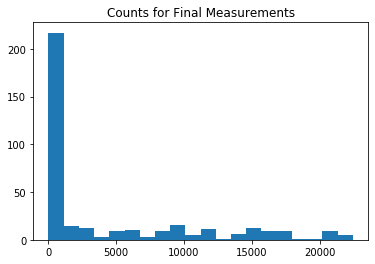

In [18]:
plot_value_counts_values_histogram(measurement_abstract_rpt_df, 'name', 'Final Measurements')

### What is the distribution of counts for final (reported) measurements per study?

In [19]:
def plot_group_by_size_histogram(df, column, name):
    counts = df.groupby(column).size()
    print(counts.describe())
    plt.title(f'Counts for {name}')
    counts = plt.hist(counts.values, bins=20)
    return counts[0]

count    24912.000000
mean        62.955604
std         28.507135
min          1.000000
25%         42.000000
50%         60.000000
75%         84.000000
max        146.000000
dtype: float64


array([ 572.,  412.,  670., 1104., 2134., 2246., 2522., 2280., 2243.,
       1826., 1757., 1723., 1715., 1138.,  873.,  901.,  558.,  177.,
         46.,   15.])

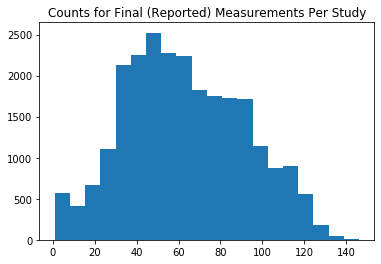

In [20]:
plot_group_by_size_histogram(measurement_abstract_rpt_df, "studyid", "Final (Reported) Measurements Per Study")

### What is the distribution of counts for total (recorded) measurements per study?

count    24471.000000
mean        33.667852
std         15.882193
min          1.000000
25%         22.000000
50%         33.000000
75%         44.000000
max        148.000000
dtype: float64


array([9.290e+02, 2.070e+03, 3.916e+03, 4.053e+03, 3.992e+03, 4.075e+03,
       2.592e+03, 1.534e+03, 7.870e+02, 2.470e+02, 1.150e+02, 8.200e+01,
       2.700e+01, 2.000e+01, 1.600e+01, 6.000e+00, 2.000e+00, 4.000e+00,
       2.000e+00, 2.000e+00])

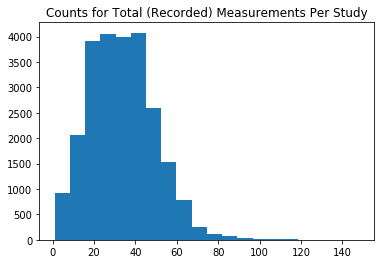

In [21]:
plot_group_by_size_histogram(measgraphref_df, "studyidk", "Total (Recorded) Measurements Per Study")

### What is the distribution of counts for total (recorded) measurements per instance?

count    254159.000000
mean          3.241616
std           2.722846
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          27.000000
dtype: float64


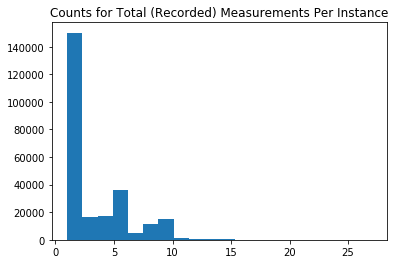

In [22]:
counts = plot_group_by_size_histogram(measgraphref_df, "instanceidk", "Total (Recorded) Measurements Per Instance")

In [23]:
counts

array([1.50143e+05, 1.61750e+04, 1.69980e+04, 3.63450e+04, 4.61400e+03,
       1.14700e+04, 1.51050e+04, 9.52000e+02, 4.71000e+02, 6.15000e+02,
       9.30000e+02, 9.50000e+01, 9.00000e+01, 7.80000e+01, 7.00000e+01,
       3.00000e+00, 4.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00])

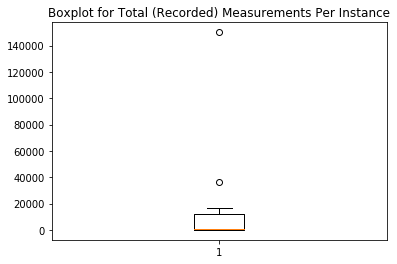

In [24]:
plt.title("Boxplot for Total (Recorded) Measurements Per Instance")
result = plt.boxplot(counts)

In [25]:
def get_outlier_thresholds(result):
    outlier_min, outlier_max = [item.get_ydata()[0] for item in result['caps']]
    return outlier_min, outlier_max

In [26]:
outlier_min, outlier_max = get_outlier_thresholds(result)
outlier_min, outlier_max

(0.0, 16998.0)

In [27]:
# TODO: filter outliers?
num_outliers = ((counts < outlier_min) | (counts > outlier_max)).sum()
num_outliers

2

### What is the distribution of counts for instances per study?

In [28]:
frame_counts_per_study_and_instance = measgraphref_df.groupby(["studyidk", "instanceidk"]).size()
len(frame_counts_per_study_and_instance)

254159

In [29]:
frame_counts_per_study_and_instance.head()

studyidk  instanceidk
2882.0    57160          4
          57162          1
          57164          8
          57166          5
          57169          2
dtype: int64

In [30]:
instance_counts_per_study = frame_counts_per_study_and_instance.reset_index().groupby('studyidk').size()
len(instance_counts_per_study)

24471

In [31]:
instance_counts_per_study.head()

studyidk
2882.0    5
2915.0    2
2965.0    1
2966.0    2
3009.0    1
dtype: int64

In [32]:
instance_counts_per_study.describe()

count    24471.000000
mean        10.386131
std          4.299754
min          1.000000
25%          7.000000
50%         11.000000
75%         13.000000
max         33.000000
dtype: float64

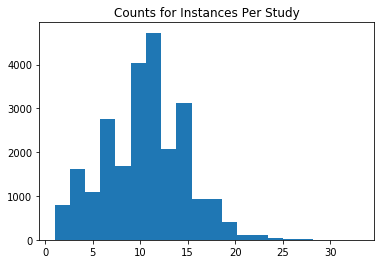

In [33]:
plt.title("Counts for Instances Per Study")
plt.hist(instance_counts_per_study.values, bins=20);

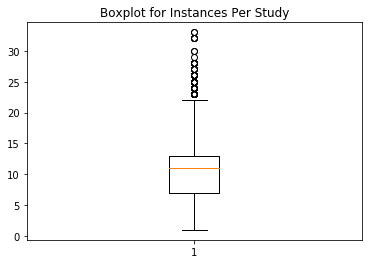

In [34]:
plt.title("Boxplot for Instances Per Study")
result = plt.boxplot(instance_counts_per_study)

In [35]:
outlier_min, outlier_max = get_outlier_thresholds(result)
outlier_min, outlier_max

(1.0, 22.0)

In [36]:
# TODO: filter outliers?
num_outliers = ((instance_counts_per_study < outlier_min) | (instance_counts_per_study > outlier_max)).sum()
num_outliers

128

### What is the distribution of counts for frames per instance?

In [37]:
frame_counts_per_instance = measgraphref_df.groupby(["instanceidk", "indexinmglist"]).size().reset_index().groupby('instanceidk').size()
len(frame_counts_per_instance)

254159

In [38]:
frame_counts_per_instance.head()

instanceidk
57160    4
57162    1
57164    2
57166    2
57169    1
dtype: int64

In [39]:
frame_counts_per_instance.describe()

count    254159.000000
mean          1.915765
std           1.327393
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          16.000000
dtype: float64

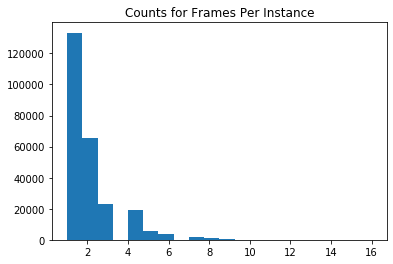

In [40]:
plt.title("Counts for Frames Per Instance")
plt.hist(frame_counts_per_instance.values, bins=20);

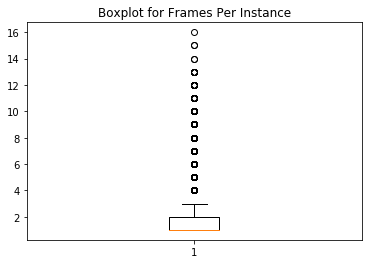

In [41]:
plt.title("Boxplot for Frames Per Instance")
result = plt.boxplot(frame_counts_per_instance)

In [42]:
outlier_min, outlier_max = get_outlier_thresholds(result)
outlier_min, outlier_max

(1.0, 3.0)

In [43]:
# TODO: filter outliers?
num_outliers = ((frame_counts_per_instance < outlier_min) | (frame_counts_per_instance > outlier_max)).sum()
num_outliers

31877

### What is the distribution of counts for measurements per frame?

In [44]:
measurement_counts_per_frame = measgraphref_df.groupby(["instanceidk", "indexinmglist"]).size()
len(measurement_counts_per_frame)

486909

In [45]:
measurement_counts_per_frame.head()

instanceidk  indexinmglist
57160        0                1
             1                1
             2                1
             3                1
57162        0                1
dtype: int64

In [46]:
measurement_counts_per_frame.describe()

count    486909.000000
mean          1.692074
std           1.044359
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           5.000000
dtype: float64

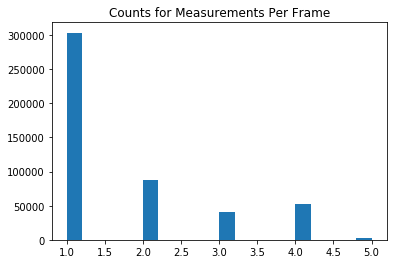

In [47]:
plt.title("Counts for Measurements Per Frame")
plt.hist(measurement_counts_per_frame.values, bins=20);

# 3. View groundtruth from measurements

* 823,886 total (recorded) instance measurements with frames
* 295,962 total (recorded) instance measurements with frames for measurements we care about
* 23,327 unique studies with total (recorded) measurements for measurements we care about
* 69,185 unique instancs with total (recorded) measurements for measurements we care about
* 162 frames with more than one view
    * 113 A4C & A2C
    * 49 A4C & PLAX
* 53,852 instances (potentially) with PLAX view
    * 27,838 instances frames with PLAX view
    * 26,014 instances frames with PLAX view potentially
* 38,880 instances frames with A4C view
* 20,908 instances frames with A2C view
* 45,782 instances frames 
* 113,640 total frames from all views

In [48]:
measgraphref_df.head()

,row_id,studyidk,measabstractnumber,meassequence,instanceidk,indexinmglist,value,howentered,imagesopinstanceuid,measurementuid
0,1.0,2882.0,187.0,0.0,57164,0,28.242271,0.0,,
1,2.0,2882.0,188.0,0.0,57164,0,7.897812,0.0,,
2,3.0,2882.0,189.0,0.0,57164,0,85.725750,0.0,,
3,4.0,2882.0,190.0,0.0,57164,0,87.190031,0.0,,
4,5.0,2882.0,191.0,0.0,57164,1,36.654466,0.0,,


In [49]:
measgraphref_df = measgraphref_df[['studyidk', 'measabstractnumber', 'instanceidk', 'indexinmglist']]
measgraphref_df.head()

,studyidk,measabstractnumber,instanceidk,indexinmglist
0,2882.0,187.0,57164,0
1,2882.0,188.0,57164,0
2,2882.0,189.0,57164,0
3,2882.0,190.0,57164,0
4,2882.0,191.0,57164,1


In [50]:
measgraphic_df.head()

,row_id,instanceidk,indexinmglist,frame
0,1.0,57160.0,0.0,0.0
1,2.0,57160.0,1.0,0.0
2,3.0,57160.0,2.0,0.0
3,4.0,57160.0,3.0,0.0
4,5.0,57162.0,0.0,5.0


In [51]:
measgraphic_df = measgraphic_df[['instanceidk', 'indexinmglist', 'frame']]
measgraphic_df.head()

,instanceidk,indexinmglist,frame
0,57160.0,0.0,0.0
1,57160.0,1.0,0.0
2,57160.0,2.0,0.0
3,57160.0,3.0,0.0
4,57162.0,0.0,5.0


In [52]:
measurement_abstract_rpt_df.head()

,row_id,studyid,measabstractnumber,name,value,unitname
0,1.0,2882.0,2.0,(P1/2t)AVM,2.491754,cm2
1,2.0,2882.0,12.0,Area TSVI,3.606348,cm2
2,3.0,2882.0,43.0,FE(el-ps4),37.032087,%
3,4.0,2882.0,46.0,FE(MDD-ps4),35.095355,%
4,5.0,2882.0,125.0,P1/2t VM,88.291224,ms


In [53]:
measurement_abstract_rpt_df = measurement_abstract_rpt_df[['studyid', 'measabstractnumber', 'name']]
measurement_abstract_rpt_df = measurement_abstract_rpt_df.rename(index=str, columns={"studyid": "studyidk"})
measurement_abstract_rpt_df.head()

,studyidk,measabstractnumber,name
0,2882.0,2.0,(P1/2t)AVM
1,2882.0,12.0,Area TSVI
2,2882.0,43.0,FE(el-ps4)
3,2882.0,46.0,FE(MDD-ps4)
4,2882.0,125.0,P1/2t VM


In [54]:
merge_df = measgraphref_df.merge(measgraphic_df, on=['instanceidk', 'indexinmglist'])
print(merge_df.shape)
merge_df.head()

(823833, 5)


,studyidk,measabstractnumber,instanceidk,indexinmglist,frame
0,2882.0,187.0,57164,0,8.0
1,2882.0,188.0,57164,0,8.0
2,2882.0,189.0,57164,0,8.0
3,2882.0,190.0,57164,0,8.0
4,2882.0,191.0,57164,1,15.0


In [55]:
merge_df = merge_df.merge(measurement_abstract_rpt_df, on=['studyidk', 'measabstractnumber'])
print(merge_df.shape)
merge_df.head()

(823832, 6)


,studyidk,measabstractnumber,instanceidk,indexinmglist,frame,name
0,2882.0,187.0,57164,0,8.0,AVIts ap4
1,2882.0,188.0,57164,0,8.0,DVIts ap4
2,2882.0,189.0,57164,0,8.0,VTS(el-ps4)
3,2882.0,190.0,57164,0,8.0,VTS(MDD-ps4)
4,2882.0,191.0,57164,1,15.0,AVItd ap4


In [56]:
MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW = ['Diám raíz Ao', 'Diám. Ao asc.', 'Diám TSVI', 'Dimensión AI']
POTENTIAL_MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW = ['Diám TSVD', 'DVItd', 'DVIts', 'SIVtd', 'PPVItd']
MEASUREMENTS_APICAL_4_CHAMBER_VIEW = ['AVItd ap4', 'VTD(el-ps4)', 'VTD(MDD-ps4)', 'VTD 4C', 'AVIts ap4', 'VTS(el-ps4)', 'VTS(MDD-ps4)', 'VTS 4C', 'Vol. AI (MOD-sp4)']
MEASUREMENTS_APICAL_2_CHAMBER_VIEW = ['AVItd ap2', 'VTD(el-ps2)', 'VTD(MDD-ps2)', 'VTD 2C', 'AVIts ap2', 'VTS(el-ps2)', 'VTS(MDD-ps2)', 'VTS 2C', 'Vol. AI (MOD-sp2)']
ALL_MEASUREMENTS = MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW + POTENTIAL_MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW + MEASUREMENTS_APICAL_4_CHAMBER_VIEW + MEASUREMENTS_APICAL_2_CHAMBER_VIEW

In [57]:
filter_df = merge_df[merge_df.name.isin(ALL_MEASUREMENTS)].copy()
print(filter_df.shape)
filter_df.head()

(295962, 6)


,studyidk,measabstractnumber,instanceidk,indexinmglist,frame,name
0,2882.0,187.0,57164,0,8.0,AVIts ap4
2,2882.0,189.0,57164,0,8.0,VTS(el-ps4)
3,2882.0,190.0,57164,0,8.0,VTS(MDD-ps4)
4,2882.0,191.0,57164,1,15.0,AVItd ap4
6,2882.0,193.0,57164,1,15.0,VTD(el-ps4)


In [58]:
filtered_measurements = filter_df['name']
filtered_measurements.value_counts()

DVItd                21102
SIVtd                21007
PPVItd               20776
AVItd ap4            17215
VTD(el-ps4)          17214
VTD(MDD-ps4)         17213
AVIts ap4            16778
VTS(el-ps4)          16777
VTS(MDD-ps4)         16776
Diám raíz Ao         15916
Dimensión AI         13149
Vol. AI (MOD-sp4)    12255
DVIts                11594
AVItd ap2             9370
VTD(el-ps2)           9369
VTD(MDD-ps2)          9368
AVIts ap2             9238
VTS(el-ps2)           9237
VTS(MDD-ps2)          9236
Vol. AI (MOD-sp2)     7625
Diám TSVI             6899
Diám. Ao asc.         5078
Diám TSVD             2559
VTD 4C                  55
VTS 2C                  53
VTD 2C                  52
VTS 4C                  51
Name: name, dtype: int64

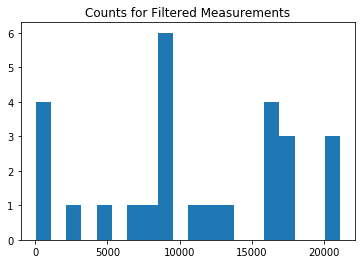

In [59]:
plt.title("Counts for Filtered Measurements")
plt.hist(filtered_measurements.value_counts().values, bins=20);

In [60]:
len(filter_df.groupby(['studyidk']).size())

23327

In [61]:
len(filter_df.groupby(['instanceidk']).size())

69185

In [62]:
MEASUREMENTS_END_DIASTOLIC = ['DVItd', 'SIVtd', 'PPVItd', 'AVItd ap4', 'VTD(el-ps4)', 'VTD(MDD-ps4)', 'VTD 4C', 'AVItd ap2', 'VTD(el-ps2)', 'VTD(MDD-ps2)', 'VTD 2C']
MEASUREMENTS_END_SYSTOLIC = ['DVIts', 'AVIts ap4', 'VTS(el-ps4)', 'VTS(MDD-ps4)', 'VTS 4C', 'AVIts ap2', 'VTS(el-ps2)', 'VTS(MDD-ps2)', 'VTS 2C']

In [63]:
filter_df['is_end_diastolic'] = filter_df['name'].isin(MEASUREMENTS_END_DIASTOLIC)
filter_df['is_end_systolic'] = filter_df['name'].isin(MEASUREMENTS_END_SYSTOLIC)

In [64]:
(filter_df['is_end_diastolic'] & filter_df['is_end_systolic']).sum()

0

In [65]:
filter_df['is_plax'] = filter_df['name'].isin(MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW)
filter_df['maybe_plax'] = filter_df['name'].isin(POTENTIAL_MEASUREMENTS_PARASTERNAL_LONG_AXIS_VIEW)
filter_df['is_a4c'] = filter_df['name'].isin(MEASUREMENTS_APICAL_4_CHAMBER_VIEW)
filter_df['is_a2c'] = filter_df['name'].isin(MEASUREMENTS_APICAL_2_CHAMBER_VIEW)

In [66]:
filter_df['view'] = ''
filter_df.loc[filter_df['is_plax']==True, 'view'] = 'plax'
filter_df.loc[filter_df['maybe_plax']==True, 'view'] = 'plax'
filter_df.loc[filter_df['is_a4c']==True, 'view'] = 'a4c'
filter_df.loc[filter_df['is_a2c']==True, 'view'] = 'a2c'

In [67]:
group_df = filter_df.groupby(['instanceidk', 'frame']).first()
group_df = group_df.drop(['measabstractnumber', 'name'], axis='columns')
print(group_df.shape)
group_df.head()

(113640, 9)


studyidk  indexinmglist  is_end_diastolic  is_end_systolic  \
instanceidk frame                                                               
57162       5.0      2882.0              0             False            False   
57164       8.0      2882.0              0             False             True   
            15.0     2882.0              1              True            False   
57571       0.0      2915.0              0              True            False   
58204       18.0     2966.0              0             False            False   

                   is_plax  maybe_plax  is_a4c  is_a2c  view  
instanceidk frame                                             
57162       5.0       True       False   False   False  plax  
57164       8.0      False       False    True   False   a4c  
            15.0     False       False    True   False   a4c  
57571       0.0      False        True   False   False  plax  
58204       18.0      True       False   False   False  plax

In [68]:
(group_df.reset_index().groupby(['instanceidk', 'indexinmglist'])['view'].nunique().eq(1)==False).sum()

0

In [69]:
(group_df.reset_index().groupby('instanceidk')['view'].nunique().eq(1)==False).sum()

162

In [70]:
is_instance_multiview = (group_df.reset_index().groupby('instanceidk')['view'].nunique().eq(1)==False).reset_index()
is_instance_multiview = is_instance_multiview.rename(index=str, columns={"view": "is_multiview"})

In [71]:
group_df = group_df.merge(is_instance_multiview, on='instanceidk')

In [72]:
frames_with_views_df = group_df
frames_with_views_df.head()

,instanceidk,studyidk,indexinmglist,is_end_diastolic,is_end_systolic,is_plax,maybe_plax,is_a4c,is_a2c,view,is_multiview
0,57162,2882.0,0,False,False,True,False,False,False,plax,False
1,57164,2882.0,0,False,True,False,False,True,False,a4c,False
2,57164,2882.0,1,True,False,False,False,True,False,a4c,False
3,57571,2915.0,0,True,False,False,True,False,False,plax,False
4,58204,2966.0,0,False,False,True,False,False,False,plax,False


In [73]:
conflict_sets = frames_with_views_df[frames_with_views_df['is_multiview']==True].groupby('instanceidk').agg({'view': lambda x: set(x)})
conflict_sets.head()

,view
instanceidk,
58207,"{a4c, plax}"
117616,"{a4c, plax}"
125620,"{a4c, plax}"
161797,"{a4c, plax}"
170419,"{a4c, plax}"


In [74]:
# TODO: filter out conflicts
conflict_sets['view'].value_counts()

{a4c, a2c}     113
{a4c, plax}     49
Name: view, dtype: int64

In [75]:
from collections import defaultdict

def get_view_counts(df):
    d = defaultdict(dict)
    d['plax'] = df['is_plax'].sum()
    d['plax_maybe'] = df['maybe_plax'].sum()
    d['plax_total'] = d['plax'] + d['plax_maybe']
    d['a4c'] = df['is_a4c'].sum()
    d['a2c'] = df['is_a2c'].sum()
    d['total'] = d['plax_total'] + d['a4c'] + d['a2c']
    return d

In [76]:
results = defaultdict(dict)
results['end_diastolic'] = get_view_counts(frames_with_views_df[frames_with_views_df['is_end_diastolic']])
results['end_systolic'] = get_view_counts(frames_with_views_df[frames_with_views_df['is_end_systolic']])
results['unsure'] = get_view_counts(frames_with_views_df[(~frames_with_views_df['is_end_diastolic']) & (~frames_with_views_df['is_end_systolic'])])
results['total'] = get_view_counts(frames_with_views_df)

In [77]:
results_df = pd.DataFrame.from_dict(results)
results_df = results_df.transpose()
results_df.head()

,a2c,a4c,plax,plax_maybe,plax_total,total
end_diastolic,9404,17253,0,19125,19125,45782
end_systolic,9044,16437,0,5947,5947,31428
unsure,2460,5190,27838,942,28780,36430
total,20908,38880,27838,26014,53852,113640


In [78]:
frames_with_views_df.to_csv('../data/02_intermediate/frames_with_views.csv')